In [1]:
import numpy as np
import os
import xarray as xr
import glob
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import BoundaryNorm
import matplotlib.colors as mcolors

In [395]:
import netCDF4
import h5py

netCDF4 version: 1.7.1.post1
h5py version: 3.9.0


In [2]:
# Base path where the folders are located
base_path = '/data/rong4/Data/ERA5/3hourly/quvw_US'

# Define the range of years and months
years = [str(year) for year in range(1979, 2019)]

def get_files(folder, component):
    # Use glob to find files matching the component pattern
    files = glob.glob(os.path.join(base_path, folder, f"era5.{component}.*.nc"))
    # Filter files by years and months
    filtered_files = [f for f in files if any(year in f for year in years)]
    return filtered_files

# Get the files for each component
u_files = get_files('u_component_of_wind', 'u_component_of_wind')
v_files = get_files('v_component_of_wind', 'v_component_of_wind')
q_files = get_files('specific_humidity', 'specific_humidity')

all_files = u_files + v_files + q_files

# # Open all datasets at once
era5 = xr.open_mfdataset(all_files, combine='by_coords')

# Open the dataset with chunking applied
era5 = xr.open_mfdataset(all_files, combine='by_coords')

# Converting to central time
era5['time'] = era5['time'] - pd.Timedelta(hours=6)

era5sgp = era5.sel(latitude=slice(39.0, 30.0), longitude=slice(-105.0, -95.0))

In [331]:
## time subsets for fig 2c) and 2f) 

era2011 = era5sgp.sel(time=slice('2011-01-01', '2011-12-31'))
era5clim = era5sgp.sel(time=slice('1979-01-01', '2018-12-31'))

# daytime composites -> averages over 18 UTC (12 LST) and 0 UTC (18 LST)
# nighttime composites -> averages over 6 UTC (0 LST) and 12 UTC (6 LST)

_2011night = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6]))
_2011day = era2011.sel(time=era2011['time'].dt.hour.isin([12, 18]))

_2011night_monthly = _2011night.resample(time='ME').mean()
_2011day_monthly = _2011day.resample(time='ME').mean()

_climnight = era5clim.sel(time=era5clim['time'].dt.hour.isin([0, 6]))
_climday = era5clim.sel(time=era5clim['time'].dt.hour.isin([12, 18]))
_climnight_day = era5clim.sel(time=era5clim['time'].dt.hour.isin([0, 6, 12, 18]))

_climnight_monthly = _climnight.groupby('time.month').mean('time')
_climday_monthly = _climday.groupby('time.month').mean('time')
_climnight_day_monthly = _climnight_day.groupby('time.month').mean('time')

_all_times = {
    
    '2011_night_monthly': _2011night_monthly,
    '2011_day_monthly': _2011day_monthly, 
    'climnight_monthly':_climnight_monthly,
    'climday_monthly':_climday_monthly

}

In [325]:
def moisture_budget_profiles(u, v, q, lat, lon):

    R = 6371000  # radius of Earth (meters)
    
    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    grid_dist = np.radians(lat[1]) - np.radians(lat[0])
    
    # shaped as (#lons, #lats) so first row represents all values for first latitude (eg: 30,30,30...)
    cos_correction = R * np.cos(lat_grid)
    
    dqdx = np.zeros_like(q)
    dqdy = np.zeros_like(q)
    
    # Loop through each pressure level
    for k in range(u.shape[0]):

        dqdx[k, :, 1:-1] = (q[k, :, 2:] - q[k, :, :-2]) / (2 * grid_dist)
        dqdy[k, 1:-1, :] = (q[k, 2:, :] - q[k, :-2, :]) / (2 * grid_dist)

        # Boundary points (one-sided differences)
        # Left and right boundaries (x-direction)
        
        dqdx[k, :, 0] = (q[k, :, 1] - q[k, :, 0]) / grid_dist
        dqdx[k, :, -1] = (q[k, :, -1] - q[k, :, -2]) / grid_dist

        # Top and bottom boundaries (y-direction)
        
        dqdy[k, 0, :] = (q[k, 1, :] - q[k, 0, :]) / grid_dist
        dqdy[k, -1, :] = (q[k, -1, :] - q[k, -2, :]) / grid_dist

        # Apply cos_correction for spherical coordinates
        dqdy[k] = (1 / R) * dqdy[k]
        dqdx[k] = (1 / cos_correction) * dqdx[k]
    
    zonal_advection = -(u * dqdx)
    
    meridional_advection = -(v * dqdy)

    # units --> 1/s
    return zonal_advection, meridional_advection


# Vertically integrated moisture flux convergence and its components
def vertically_integrated_mfc(u_levels, v_levels, q_levels, pressure_levels, latitude, longitude):

    g = 9.81  # gravitational acceleration in m/s^2
    
    rho_water = 1000 # kg/m^3
    
    scale_factor = 1000 * 60 * 60 * 24 # to convert from m/s --> mm/day in final computation
    
    zonal_adv_levels, meridional_adv_levels = moisture_budget_profiles(u_levels, v_levels, q_levels, latitude, longitude)

    dp = np.diff(pressure_levels)
    
    zonal_adv_profile = []
    merid_adv_profile = []
    
    # The integrations (for full column) are 2D
    zonal_adv_int = np.zeros_like(zonal_adv_levels[0], dtype=np.float64)
    meridional_adv_int = np.zeros_like(meridional_adv_levels[0], dtype=np.float64)

    for i in range(len(dp)):
        
        zonal_adv_int += 0.5 * (zonal_adv_levels[i] + zonal_adv_levels[i+1]) * dp[i]
        meridional_adv_int += 0.5 * (meridional_adv_levels[i] + meridional_adv_levels[i+1]) * dp[i]
                
        zonal_adv_profile.append(0.5 * (zonal_adv_levels[i] + zonal_adv_levels[i+1]) * dp[i])
        merid_adv_profile.append(0.5 * (meridional_adv_levels[i] + meridional_adv_levels[i+1]) * dp[i])
        

    zonal_adv_integrated = zonal_adv_int * (1/g) * (1/rho_water) * scale_factor
    meridional_adv_integrated = meridional_adv_int * (1/g) * (1/rho_water) * scale_factor
    
    zonal_adv_profile = np.array(zonal_adv_profile) * (1/g) * (1/rho_water) * scale_factor
    merid_adv_profile = np.array(merid_adv_profile) * (1/g) * (1/rho_water) * scale_factor

    # Units --> mm/day
    return zonal_adv_integrated, meridional_adv_integrated, zonal_adv_profile, merid_adv_profile


In [401]:
# def int_test(u_levels, v_levels, q_levels, pressure_levels, latitude, longitude):
    
#     g = 9.81  # gravitational acceleration in m/s^2
    
#     rho_water = 1000  # kg/m^3
    
#     scale_factor = 1000 * 60 * 60 * 24  # convert from m/s to mm/day in final computation
    
#     zonal_adv_levels, meridional_adv_levels = moisture_budget_profiles(u_levels, v_levels, q_levels, latitude, longitude)

#     # Calculate the pressure differences
#     dp = np.diff(pressure_levels)

#     # Integrate the moisture advection profiles over pressure levels
#     zonal_adv_integrated = np.trapz(zonal_adv_levels, dx=dp[:, np.newaxis, np.newaxis], axis=0)
    
#     meridional_adv_integrated = np.trapz(meridional_adv_levels, dx=dp[:, np.newaxis, np.newaxis], axis=0)

#     # Convert to mm/day
#     zonal_adv_integrated = zonal_adv_integrated * (1 / g) * (1 / rho_water) * scale_factor
    
#     meridional_adv_integrated = meridional_adv_integrated * (1 / g) * (1 / rho_water) * scale_factor

#     # Calculate the profiles (for the sake of completeness; if needed)
#     zonal_adv_profile = (0.5 * (zonal_adv_levels[:-1] + zonal_adv_levels[1:]) * dp[:, np.newaxis, np.newaxis]) * (1 / g) * (1 / rho_water) * scale_factor
    
#     merid_adv_profile = (0.5 * (meridional_adv_levels[:-1] + meridional_adv_levels[1:]) * dp[:, np.newaxis, np.newaxis]) * (1 / g) * (1 / rho_water) * scale_factor

#     # Units --> mm/day
#     return zonal_adv_integrated, meridional_adv_integrated, zonal_adv_profile, merid_adv_profile

## Checking with known analytical solution

In [370]:
def known_q_function(lat, lon):

    return np.sin(np.radians(lat)) * np.cos(np.radians(lon))

def analytical_derivatives(lat, lon):

    lon_grid, lat_grid = np.meshgrid(np.radians(lon), np.radians(lat))
    
    R = 6371000  # radius of Earth (meters)
    
    cos_correction = R * np.cos(lat_grid)
    
    dqdx_analytical = -np.sin(lat_grid) * np.sin(lon_grid) / cos_correction
    
    dqdy_analytical = np.cos(lat_grid) * np.cos(lon_grid) / R
    
    return -dqdx_analytical, -dqdy_analytical

pressure_levels = 1

latitudes = era5sgp['latitude'].data[::-1]

longitudes = era5sgp['longitude'].data

# Generate specific humidity using the known function
q = np.zeros((pressure_levels, len(latitudes), len(longitudes)))
    
for i in range(len(latitudes)):

    for j in range(len(longitudes)):

        q[:, i, j] = known_q_function(latitudes[i], longitudes[j])

u = np.ones_like(q)

v = np.ones_like(q)  

# Execute your function
zonal_advection, meridional_advection = moisture_budget_profiles(u, v, q, latitudes, longitudes)

# Get analytical derivatives
dqdx_analytical, dqdy_analytical = analytical_derivatives(latitudes, longitudes)

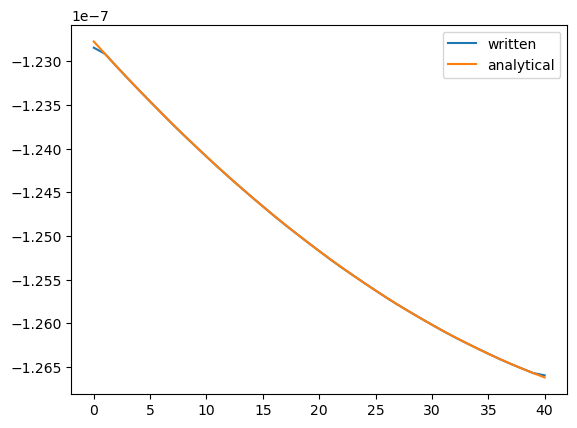

In [371]:
idx = 36
plt.plot(zonal_advection[0][idx], label='written')
plt.plot(dqdx_analytical[idx], label='analytical')
plt.legend()
plt.show()

Figure 6 c) & f) reproduction 

In [326]:
results = {}

# Loop through the datasets
for df_name, df in _all_times.items():
    print(df_name)
    identifier = df_name
    u = df['u'].load().data[:, :, ::-1, :]  
    v = df['v'].load().data[:, :, ::-1, :]  
    q = df['q'].load().data[:, :, ::-1, :] 
    levels = df['level'].data * 100 
    latitude = df['latitude'].data[::-1]
    longitude = df['longitude'].data  
    
    zonals = []
    merids = []
    
    # Loop through each month 
    for i in range(u.shape[0]):
        # Calculate zonal and meridional advection (single value) for every gridpoint
        zonal_adv_int, meridional_adv_int, _, _ = vertically_integrated_mfc(u[i], v[i], q[i], levels, latitude, longitude)

        # Average integral values over domain
        zonals.append(zonal_adv_int.mean())
        merids.append(meridional_adv_int.mean())

    results[identifier] = {
        'zonal': zonals,
        'meridional': merids  
    }


2011_night_monthly
2011_day_monthly
climnight_monthly
climday_monthly


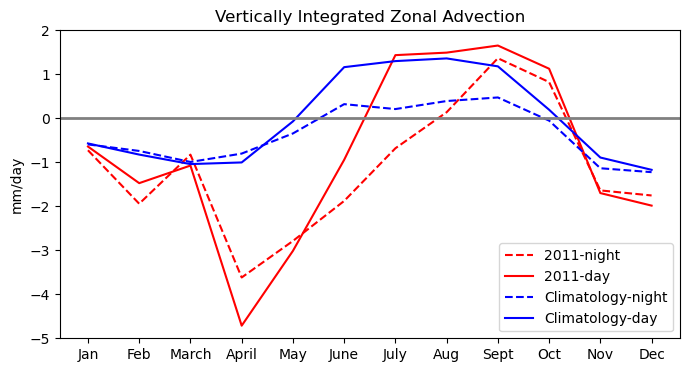

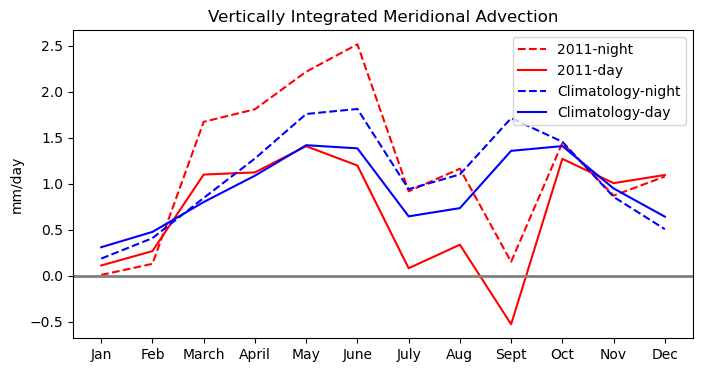

In [329]:
#plotting zonal advection

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, results['2011_night_monthly']['zonal'], color='red', linestyle='--', label='2011-night')
plt.plot(months, results['2011_day_monthly']['zonal'], color='red', label='2011-day')
plt.plot(months, results['climnight_monthly']['zonal'], color='blue', linestyle='--', label='Climatology-night')
plt.plot(months, results['climday_monthly']['zonal'], color='blue', label='Climatology-day')
plt.axhline(0, color='grey', linewidth=2)
plt.ylabel("mm/day")
plt.title("Vertically Integrated Zonal Advection")
plt.ylim(-5,2)
plt.legend()
plt.show()

#plotting meridional advection

fig, ax = plt.subplots(figsize=(8, 4))

months=["Jan", "Feb", "March", "April", "May", "June", "July", "Aug", "Sept", "Oct", "Nov", "Dec"]

plt.plot(months, results['2011_night_monthly']['meridional'], color='red', linestyle='--', label='2011-night')
plt.plot(months, results['2011_day_monthly']['meridional'], color='red', label='2011-day')
plt.plot(months, results['climnight_monthly']['meridional'], color='blue', linestyle='--', label='Climatology-night')
plt.plot(months, results['climday_monthly']['meridional'], color='blue', label='Climatology-day')
plt.axhline(0, color='grey', linewidth=2)
plt.title("Vertically Integrated Meridional Advection")
plt.ylabel("mm/day")
# plt.ylim(-5,2)
plt.legend()
plt.show()

Figure 6 a) b) d) and f) reproduction 

In [312]:
era2011day_and_night = era2011.sel(time=era2011['time'].dt.hour.isin([0, 6, 12, 18]))
era2011monthly = era2011day_and_night.resample(time='ME').mean()

u_2011 = era2011monthly['u'].load().data[:, :, ::-1, :]  
v_2011 = era2011monthly['v'].load().data[:, :, ::-1, :]  
q_2011 = era2011monthly['q'].load().data[:, :, ::-1, :] 
levels = era2011monthly['level'].data * 100 
latitude = era2011monthly['latitude'].data[::-1]
longitude = era2011monthly['longitude'].data

zonal_profile = []
merid_profile = []
    
# Loop through each month 
for i in range(u_2011.shape[0]):
    _, _, _2011_zonal_adv, _2011_merid_adv = vertically_integrated_mfc(u_2011[i], v_2011[i], q_2011[i], levels, latitude, longitude)
    zonal_profile.append(_2011_zonal_adv)
    merid_profile.append(_2011_merid_adv)

In [314]:
zonal_profile = np.array(zonal_profile)
merid_profile = np.array(merid_profile)

all_months_zonal_profiles = []
for month in range(zonal_profile.shape[0]):
    prof = zonal_profile[month].mean(axis=(1, 2))
    all_months_zonal_profiles.append(prof)
    
all_months_merid_profiles = []
for month in range(merid_profile.shape[0]): 
    prof = merid_profile[month].mean(axis=(1, 2))
    all_months_merid_profiles.append(prof)

Figure 6b) and e)

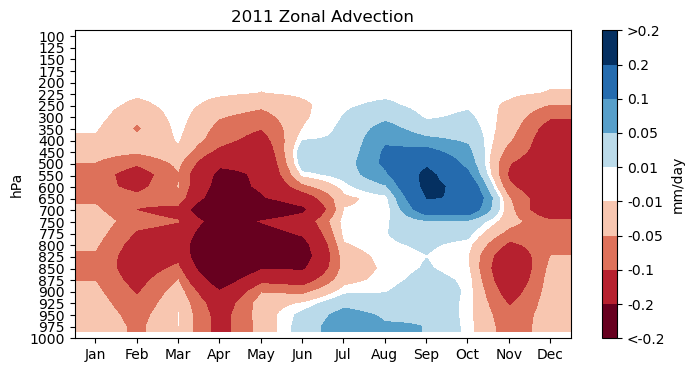

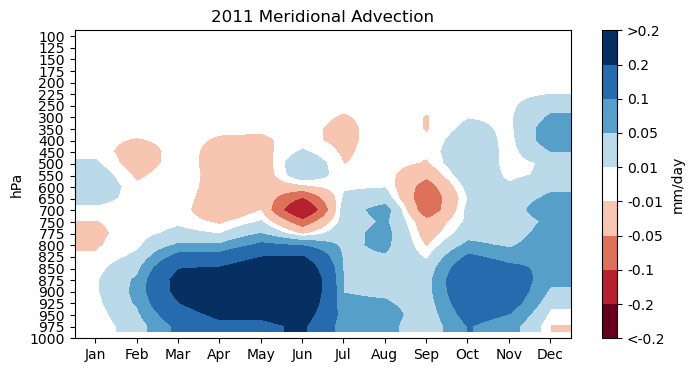

In [363]:
# Define advection profiles and titles
advection_profiles = [all_months_zonal_profiles, all_months_merid_profiles]
titles = ['Zonal', 'Meridional']

pressure_levels = era2011monthly['level'].data[2:]

# Loop through each advection profile
for i, arr in enumerate(advection_profiles): 
    
    plt.figure(figsize=(8, 4))
    
    # Subset only for pressure levels up to 100 hPa
    hovmoller_data = np.array(arr)[:,2:]

    # Updated levels with boundary values to capture extremes
    levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])

    # Custom colormap with a white segment between -0.01 and 0.01
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels)-1)

    # Normalize the data based on defined levels
    norm = mcolors.BoundaryNorm(levels, ncolors=len(levels)-1, clip=True)

    # Plotting the Hovmöller data
    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    plt.ylabel('hPa')
    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.yticks(np.arange(len(pressure_levels)), pressure_levels)
    plt.gca().invert_yaxis()
    
    # Adjusting the color bar ticks and labels
    cbar = plt.colorbar(label='mm/day', ticks=levels)
    cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])

    # Show the plot with the correct title
    plt.title('2011 {} Advection'.format(titles[i]))
    plt.show()


In [332]:
u_clim = _climnight_day_monthly['u'].load().data[:, :, ::-1, :]  
v_clim = _climnight_day_monthly['v'].load().data[:, :, ::-1, :]  
q_clim = _climnight_day_monthly['q'].load().data[:, :, ::-1, :] 
levels = _climnight_day_monthly['level'].data * 100 
latitude = _climnight_day_monthly['latitude'].data[::-1]
longitude = _climnight_day_monthly['longitude'].data

In [333]:
zonal_profile_clim = []
merid_profile_clim = []
    
# Loop through each month 
for i in range(u_clim.shape[0]):
    _, _, clim_zonal_adv, clim_merid_adv = vertically_integrated_mfc(u_clim[i], v_clim[i], q_clim[i], levels, latitude, longitude)
    zonal_profile_clim.append(clim_zonal_adv)
    merid_profile_clim.append(clim_merid_adv)

In [334]:
all_months_zonal_profiles_clim = []
for month in zonal_profile_clim: 
    month_profile = np.mean(month, axis=(1, 2))
    all_months_zonal_profiles_clim.append(month_profile)
    
all_months_merid_profiles_clim = []
for month in merid_profile_clim: 
    month_profile = np.mean(month, axis=(1, 2))
    all_months_merid_profiles_clim.append(month_profile)

Figure 6a) and d)

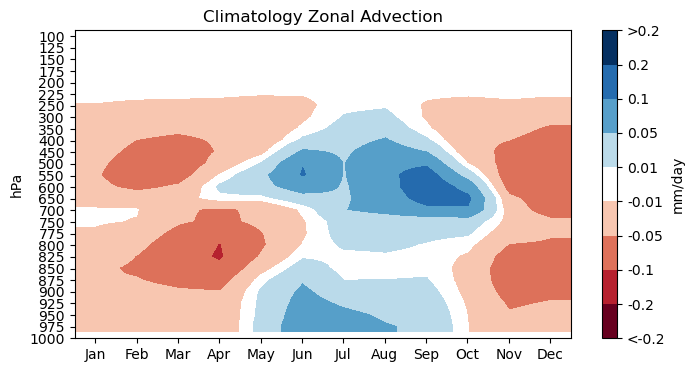

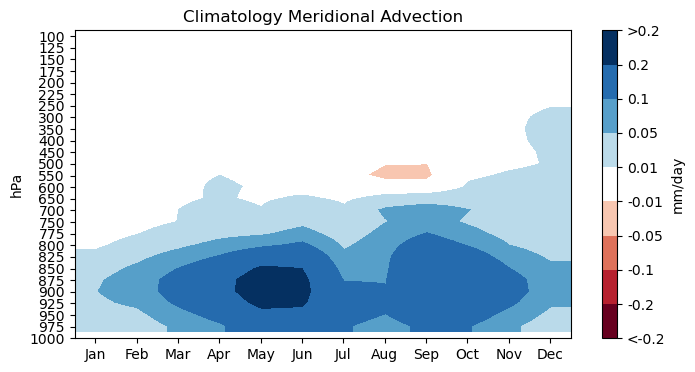

In [369]:
advection_profiles = [all_months_zonal_profiles_clim, all_months_merid_profiles_clim]
titles = ['Zonal', 'Meridional']

pressure_levels = _climnight_day_monthly['level'].data[2:]

for i, arr in enumerate(advection_profiles):  # Use enumerate to get both index and array
    
    hovmoller_data = np.array(arr)[:,2:]

    levels = np.array([-1, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.2, 1])

    # Create a custom colormap with a white segment between -0.01 and 0.01
    colors = ['#67001f', '#b2182b', '#d6604d', '#f4a582', 'white', 'white', '#92c5de', '#4393c3', '#2166ac', '#053061']
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_coolwarm", colors, N=len(levels)-1)

    # Normalize the data based on defined levels
    norm = mcolors.BoundaryNorm(levels, ncolors=len(levels)-1, clip=True)

    plt.figure(figsize=(8, 4)) #width, height

    plt.imshow(hovmoller_data.T, aspect='auto', origin='lower', cmap=cmap, norm=norm, interpolation='bilinear')
    
    plt.ylabel('hPa')

    plt.xticks(np.arange(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

    plt.yticks(np.arange(27), pressure_levels)
    
    plt.gca().invert_yaxis()

    cbar = plt.colorbar(label='mm/day', ticks=levels)
    cbar.ax.set_yticklabels(['<-0.2', '-0.2', '-0.1', '-0.05', '-0.01', '0.01', '0.05', '0.1', '0.2', '>0.2'])
    plt.title('Climatology {} Advection'.format(titles[i]))
    plt.show()


# Checking analytical solution to compare to function

In [ ]:
# # Compare results
# # We will calculate numerical derivatives as well to check the accuracy
# def numerical_derivative(q, axis=0, h=1e-5):
#     q_shifted_plus = np.roll(q, -1, axis=axis)
#     q_shifted_minus = np.roll(q, 1, axis=axis)
#     return (q_shifted_plus - q_shifted_minus) / (2 * h)

# # Calculate numerical derivatives
# dqdx_numerical = numerical_derivative(q, axis=2)  # Derivative with respect to longitude
# dqdy_numerical = numerical_derivative(q, axis=1)  # Derivative with respect to latitude

# # Check differences
# difference_dqdx = np.abs(zonal_advection - dqdx_numerical)
# difference_dqdy = np.abs(meridional_advection - dqdy_numerical)

# # Calculate and print metrics (for example, mean absolute error)
# mae_dqdx = np.mean(difference_dqdx)
# mae_dqdy = np.mean(difference_dqdy)

# print(f'Mean Absolute Error for Zonal Derivative: {mae_dqdx}')
# print(f'Mean Absolute Error for Meridional Derivative: {mae_dqdy}')

# # Plot the differences for visualization
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.title("Zonal Derivative Difference")
# plt.imshow(difference_dqdx.mean(axis=0), aspect='auto', origin='lower')
# plt.colorbar()
# plt.subplot(1, 2, 2)
# plt.title("Meridional Derivative Difference")
# plt.imshow(difference_dqdy.mean(axis=0), aspect='auto', origin='lower')
# plt.colorbar()
# plt.show()